In [1]:
import argparse
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import math
from model import *
from utils import *

In [2]:
parser = argparse.ArgumentParser('Proyecto_8091', add_help=False)
parser.add_argument('--data_folder', default='./data', type=str, help='Folder path to dataset')
parser.add_argument('--magnetometry_folder', default='Datos_Magnetometria_Anomalia_Magnetica_de_Campo_Total', type=str, help='Folder path to magnetometry data')
parser.add_argument('--gravimetry_folder', default='Datos_Gravimetria_Anomalia_Residual', type=str, help='Folder path to gravimetry data')
args = parser.parse_args(args=[])

# load data
magnetometry_path = os.path.join(args.data_folder, args.magnetometry_folder, "Puntos_Grilla_Anomalia_Magnetica_de_Campo_Total_SGC.xlsx")
gravimetry_path = os.path.join(args.data_folder, args.gravimetry_folder, "Puntos_Grilla_Anomalia_Residual_SGC.xlsx")

df_magnetometry = pd.read_excel(magnetometry_path)
df_gravimetry = pd.read_excel(gravimetry_path)

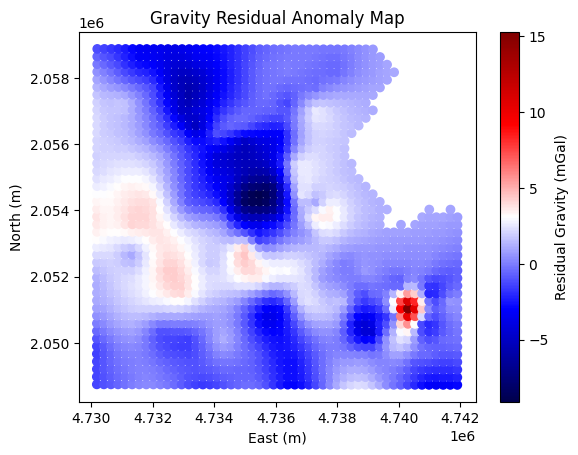

In [3]:
## Visualization
# Scatter plot of residual gravity anomaly
plt.scatter(df_gravimetry["Este"], df_gravimetry["Norte"], c=df_gravimetry["Anomalia_Residual"], cmap="seismic")
plt.colorbar(label="Residual Gravity (mGal)")
plt.xlabel("East (m)")
plt.ylabel("North (m)")
plt.title("Gravity Residual Anomaly Map")
plt.show()

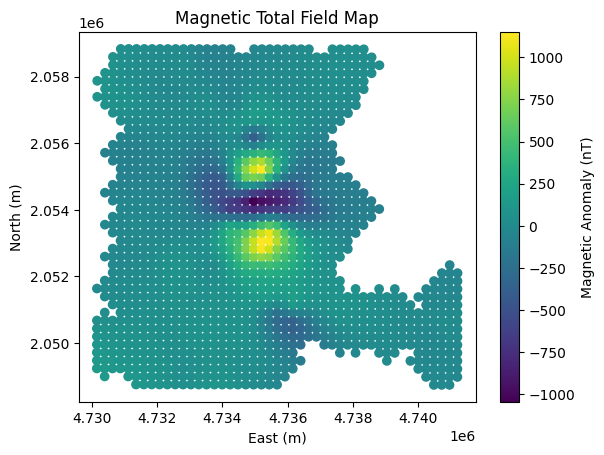

In [4]:
# Scatter plot of magnetic anomaly
plt.scatter(df_magnetometry["Este"], df_magnetometry["Norte"], c=df_magnetometry["Anomalia_Magnetica_Campo_Total"], cmap="viridis")
plt.colorbar(label="Magnetic Anomaly (nT)")
plt.xlabel("East (m)")
plt.ylabel("North (m)")
plt.title("Magnetic Total Field Map")
plt.show()

In [5]:
# Coordinates and values
x_magn = df_magnetometry["Este"].values
y_magn = df_magnetometry["Norte"].values
z_magn = df_magnetometry["Anomalia_Magnetica_Campo_Total"].values

grid_x_magn1, grid_y_magn1 = np.mgrid[x_magn.min():x_magn.max():200j, y_magn.min():y_magn.max():200j]

In [6]:
# numpy matrix
coords_magn = np.stack([x_magn, y_magn], axis=1).astype(np.float32)   # [M, 2]
targets_magn = z_magn.astype(np.float32).reshape(-1, 1)               # [M, 1]

targets_magn_max = np.max(targets_magn)   
targets_magn_min = np.min(targets_magn)   

# Normalizer
norm_magn = MinMaxNormalizer().fit(coords_magn, targets_magn)
Xm_n, Ym_n = norm_magn.transform(coords_magn, targets_magn)

# DataLoaders
ds_magn = TensorDataset(torch.from_numpy(Xm_n), torch.from_numpy(Ym_n))

dl_magn = DataLoader(ds_magn, batch_size=256, shuffle=True)

In [7]:
#Split dataloader
batch_size = 256
train_magn, val_magn = train_val_split(ds_magn, val_ratio=0.2)

dl_magn_train = DataLoader(train_magn, batch_size=batch_size, shuffle=True, num_workers=0)
dl_magn_val   = DataLoader(val_magn,   batch_size=batch_size, shuffle=False, num_workers=0)


In [8]:
###### Training
activation = "wire"

model_wire = CMLP(
    in_features=2, out_features=1,
    hidden_layers=5, hidden_units=512,
    activation='wire', wire_omega=1.0, wire_sigma=1.0  # synthetic-like defaults
)

optimizer = torch.optim.Adam(model_wire.parameters(), lr=1e-3)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=2e-4,
    steps_per_epoch=len(train_magn),
    epochs=100
)

loss = []

epochs = 5000

for epoch in range(epochs):
    for batch_magn in dl_magn_train:
        optimizer.zero_grad()
        coords_magn, target_magn = batch_magn
        pred_magn = model_wire(coords_magn)

        loss = criterion(pred_magn,target_magn)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 100 == 0:
        torch.save(model_wire.state_dict(), f'checkpoints/model_wire_{epochs}_{activation}.pth')
    print("Epoch: ", epoch, " Loss: ", loss.item())
        


Epoch:  0  Loss:  0.017810743302106857
Epoch:  1  Loss:  0.06054640933871269
Epoch:  2  Loss:  0.010758094489574432
Epoch:  3  Loss:  0.03925670310854912
Epoch:  4  Loss:  0.020683016628026962
Epoch:  5  Loss:  0.011613829992711544
Epoch:  6  Loss:  0.020770257338881493
Epoch:  7  Loss:  0.009160993620753288
Epoch:  8  Loss:  0.013867544010281563
Epoch:  9  Loss:  0.01587962545454502
Epoch:  10  Loss:  0.007859926670789719
Epoch:  11  Loss:  0.010632622055709362
Epoch:  12  Loss:  0.010629584081470966
Epoch:  13  Loss:  0.00908615905791521
Epoch:  14  Loss:  0.009157838299870491
Epoch:  15  Loss:  0.009266924113035202
Epoch:  16  Loss:  0.006338566541671753
Epoch:  17  Loss:  0.009610474109649658
Epoch:  18  Loss:  0.0067244102247059345
Epoch:  19  Loss:  0.009365161880850792
Epoch:  20  Loss:  0.007892083376646042
Epoch:  21  Loss:  0.010751977562904358
Epoch:  22  Loss:  0.008727078326046467
Epoch:  23  Loss:  0.0053493184968829155
Epoch:  24  Loss:  0.005491947755217552
Epoch:  25  

In [9]:
for batch_magn in dl_magn_val:
    coords_magn, target_magn = batch_magn
    
    model_wire.eval()
    pred_magn = model_wire(coords_magn)
    print("Coords: ", coords_magn[0], " Target: ", target_magn[0].item(), " Prediction: ", pred_magn[0].item())
    print("MSE: ", criterion(pred_magn,target_magn).item())
    break

Coords:  tensor([0.9996, 0.0950])  Target:  0.46997249126434326  Prediction:  0.46708226203918457
MSE:  0.006576229818165302


In [ ]:
######  agregar code inferencia